# HCP Gambling - rfMRI analysis

This analysis aims to show whether the ACT-R models prediction (declarative model vs. RL modle) could also predict resting state brain connectivity

In [1]:
from __future__ import division
from lasso_func import *

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

/Users/cheryang/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


----

### Load ACT-R Model Preidction Data

The dependent variable is the ACTR model prediction M1 or M2


In [2]:
power2011 = pd.read_csv('../bin/power_2011.csv', usecols=["ROI", "X", "Y", "Z", "Network", "Color", "NetworkName"]) 

# convert to 1/0 dummy variable 
model_dat = pd.read_csv('../actr-models/model_output/MODELLogLikelihood.csv')
model_dat['best_model1'] = np.where(model_dat['best_model']== 'm1', 1, 0)

---
### Load Subj Cocountivty Matrix

First, let's compare differnt correlation matrix

- raw: not regress out motion artifacts
- mr: motion regression
- r: peaerson correlation matrix
- pr: partial correlation


In [3]:
subj_wide1 = load_subj('./rest_corr/REST1/', model_dat, corr_fname='raw_pcorr.txt')
subj_wide2 = load_subj('./rest_corr/REST1/', model_dat, corr_fname='mr_pcorr.txt')
subj_wide3 = load_subj('./rest_corr/REST1/', model_dat, corr_fname='raw_corr_pearson.txt')
subj_wide4 = load_subj('./rest_corr/REST1/', model_dat, corr_fname='mr_corr_pearson.txt')

comp = pd.DataFrame()
comp['raw_pr'] = subj_wide1['[1, 2]']
comp['mr_pr'] = subj_wide2['[1, 2]']
comp['raw_r'] = subj_wide3['[1, 2]']
comp['mr_r'] = subj_wide4['[1, 2]']
comp.head()

,raw_pr,mr_pr,raw_r,mr_r
0,0.252328,0.223943,0.740244,0.526020
1,0.402622,0.393709,0.586992,0.902781
2,0.193616,0.193988,0.587789,0.656372
3,0.129045,0.128777,0.684227,0.845326
4,0.209995,0.213416,0.632762,0.633336


Next, convert many connectivity matries into a wide matrix `subj_wide`, with a dimension of `N`(number of subjects) x `M` (264 x 264 = 69696)

In [4]:
subj_wide = load_subj('./rest_corr/REST1/', model_dat)
DV = 'best_model1'  # define dependent variable(behavioral measurements) # DV = 'MLAT5' #MLAT5, alpha2, SymmetrySpan

And now, let’s visualize the histogram of the dependent variable we are trying to predict:

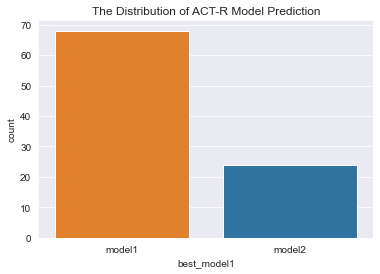

DV distribution:
 1    68
0    24
Name: best_model1, dtype: int64


In [5]:
sns.countplot(DV, data=subj_wide)
plt.title("The Distribution of ACT-R Model Prediction")
plt.gca().set_xticklabels( ('model2', 'model1') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_wide[DV].value_counts(normalize=False))

Imbalance training data might bias the logistic model, so we need to upsample the minority class by randomly adding more data from minrority class

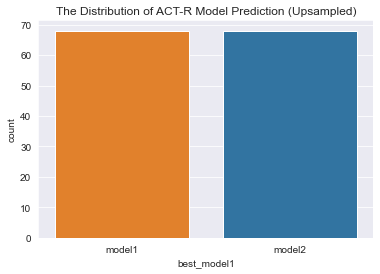

DV distribution:
 1    68
0    68
Name: best_model1, dtype: int64


In [6]:
subj_balance = balance_training_sample(subj_wide, DV)
sns.countplot(DV, data=subj_balance)
plt.title("The Distribution of ACT-R Model Prediction (Upsampled)")
plt.gca().set_xticklabels( ('model2', 'model1') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_balance[DV].value_counts(normalize=False))

### Define Brain Region of Interest

Exclude some brain regions if necessary. 

Now, we obtain connectivity vector for NOI by combining `censor` with `subj_censored`

In [7]:
# define network of interest (NOI)
NOI = [
        "Uncertain",
        "Sensory/somatomotor Hand",
        "Sensory/somatomotor Mouth",
        "Cingulo-opercular Task Control",
        "Auditory",
        "Default mode",
        "Memory retrieval?",
        "Ventral attention",
        "Visual",
        "Fronto-parietal Task Control",
        "Salience",
        "Subcortical",
        "Cerebellar",
        "Dorsal attention"
]

In [8]:
censor = get_vector_df(power2011, NOI)        # filter some region connections
subj_censored = get_subj_df(subj_balance, censor)

features = list(subj_censored.columns)[2:]
print('The dimension of subj_censored is', subj_censored.shape, 'N = subj (upsampled), M = connections')

The dimension of subj_censored is (136, 34718) N = subj (upsampled), M = connections


---

### Logistic Regression Models

Here, we will use logistic regression with L1 penalty (LASSO) to identify the functional connectivity patterns that predict the ACT-R model outcome variable `best_model`: model1 / model2. To better fit in logistic model, this variable is changed to `best_model1` =  1/0


### Split training data and Testing set.

We will use cross-validation method (cv=10) OR leave-one-out(LOO) to find best L1 parameter `lambda`

In [9]:
### 90% split
train_data, test_data = train_test_split(subj_censored, test_size=0.1, random_state=1)  

print('The dimension of train_data', train_data.shape)
print('The dimension of test_data', test_data.shape)

The dimension of train_data (122, 34718)
The dimension of test_data (14, 34718)


### Grid-Search HyperParameter (lambda) Tunning

Next, let's find the best `lambda_values` for Lasso Regression using grid search hyperparameter tunning

Visualize the  `lambda` and `coef_` path

- Method1: Standard Grid Search

- Method2: Random Grid Search (more efficient)

- Method3: Halving Grid Search (even more efficient, but may not accurate)

Best Score: 0.9773809523809524
Best Hyperparameters: {'C': 2.6826957952797246}
Time usage: 280.393s


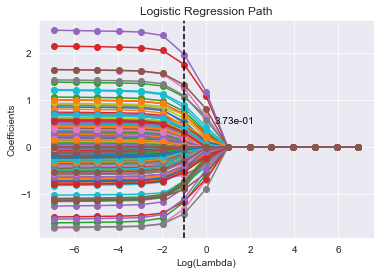

Time usage: 60.003s


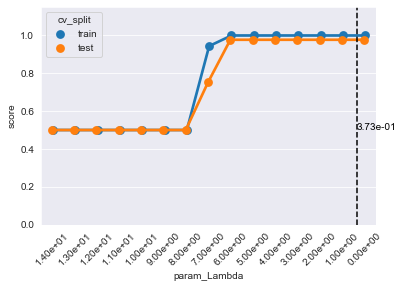

In [10]:
method = 'random_gs'

if method == 'standard_gs':
    # standar GS is too slow (400s +)
    grid_result1 = grid_search_lasso(subj_censored, features, DV, num_cv=20, plot_path=True)
    _ = plot_regularization_score(grid_result1)
    
elif method == 'random_gs':
    # random GS (200s +)
    grid_result2 = random_grid_search_lasso(subj_censored, features, DV, num_cv=20, plot_path=True)
    _ = plot_regularization_score(grid_result2)
    
elif method == 'halving_gs':
    # halving GS (100s +)
    grid_result3 = halving_search_lasso(subj_censored, features, DV, plot_path=True)
    _ = plot_regularization_score(grid_result3)

In [12]:
grid_result = grid_result2

Let's see how does the validation accuracy(score) changes as the L1(lambda) changes

### Re-Train Logistic Model

Next, we need to retrain the logistic model with best `lambda` 


In [13]:
best_C = grid_result.best_params_['C']
print('best lambda', 1.0/best_C)

best_lasso_model = LogisticRegression(penalty='l1', solver='saga', C=best_C, fit_intercept=False)
best_lasso_model.fit(subj_censored[features], subj_censored[DV])

best lambda 0.3727593720314942


LogisticRegression(C=2.6826957952797246, fit_intercept=False, penalty='l1',
                   solver='saga')

-  Method1: Leave-One-Out: Applying the leave-one-out(LOO) method, we can evaluate the accuracy, ROC, and confusion matrix


- Method2 Cross-Validation (20): If LOO method is tom computationally expensive, try cross-validation = 20

In [14]:
method = 'loo'

if method == 'loo':
    # LOO is computationally expensive (400s +)
    all_ytrue, all_yhat, all_yprob = loocv_logistic_retrain(subj_censored, features, DV, best_C)
    loo_accuracy = accuracy_score(all_ytrue, all_yhat)

    print('The Leave-One-Out Accuracy Score: {:.4f}'.format(loo_accuracy))

elif method == 'cv20':
    # CV = 20 is more efficient (200s +)

    all_ytrue, all_yhat, all_yprob, _ =cv_logistic_retrain(subj_censored, features, DV, best_C, 20)
    loo_accuracy = accuracy_score(all_ytrue, all_yhat)

    print('The Cross-Validation(20) Accuracy Score: {:.4f}'.format(loo_accuracy))
    

Time Usage (s) 732.7311
The Leave-One-Out Accuracy Score: 0.9779


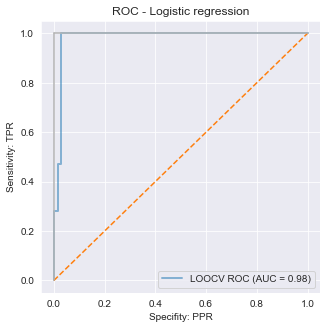

In [15]:
plot_roc_curve_loo(all_ytrue, all_yprob)

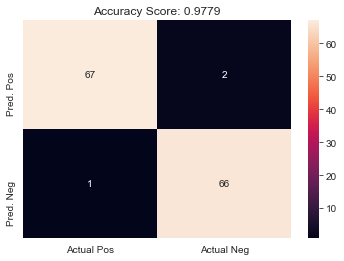

In [16]:
plot_confusion_matrix_loo(subj_censored[DV].values, all_yhat)

Let's look at strongest connections and the beta dataframe

In [17]:
betas = best_lasso_model.coef_[0]

min_connID = None
min_beta = betas[0]

max_connID = None
max_beta = betas[0]
for i in range(0, len(betas)):
    if betas[i] < min_beta:
        min_beta = betas[i]
        min_connID = features[i+1]
    if betas[i] > max_beta:
        max_beta = betas[i]
        max_connID = features[i+1]

print('min_beta', min_connID, min_beta)
print('max_beta',  max_connID, max_beta)

min_beta [141, 182] -0.7262479520895398
max_beta [187, 189] 1.0203729111516149


In [18]:
beta_df = pd.DataFrame({'connID':features, 'beta':best_lasso_model.coef_[0]})
total_bata, _ = beta_df.shape
survived_bata, _ = beta_df[beta_df['beta']!=0.0].shape

print('Total beta:', total_bata, '\nSurvive bata:', survived_bata, '\nPercentage', round(survived_bata/total_bata, 4))

Total beta: 34716 
Survive bata: 572 
Percentage 0.0165


### Prediction vs. Observed


Next, let's see the predict_proba vs. observation labels

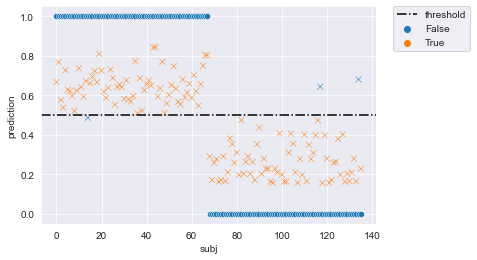

In [19]:
plot_prediction_loo(all_ytrue, all_yhat, all_yprob, 0.5)

### Brain Mapping

Next, look at the beta value mapped on brain 

In [20]:
adj_beta, power_coords = map_beta(censor, best_lasso_model.coef_[0], power2011)

The beta distribution

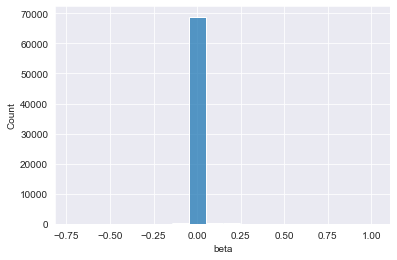

In [21]:
sns.histplot(data=pd.DataFrame({'beta':matrix2vector(adj_beta)}), x='beta')
plt.show()

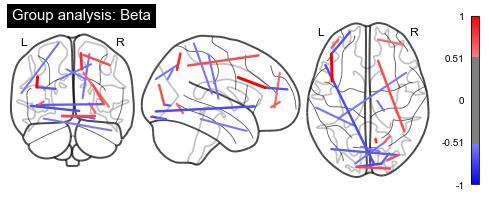

In [22]:
# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(adj_beta, power_coords,
                         edge_threshold='99.95%',
                         node_color='black',
                         colorbar=True,
                         node_size=0,
                         alpha=.2,
                         title='Group analysis: Beta')
plt.show()


In [23]:
plotting.view_connectome(adj_beta, power_coords, 
                         edge_threshold='99.95%',
                         colorbar=True,
                         node_size=1,
                         title='Group analysis: Beta').open_in_browser()

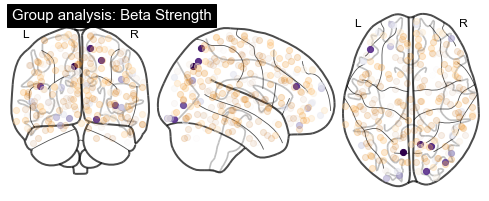

In [25]:
plotting.plot_connectome_strength(adj_beta, power_coords,
                         cmap = 'PuOr',
                         title='Group analysis: Beta Strength')

plotting.show()

In [36]:
adj_beta2 = adj_beta.replace(0, np.nan)

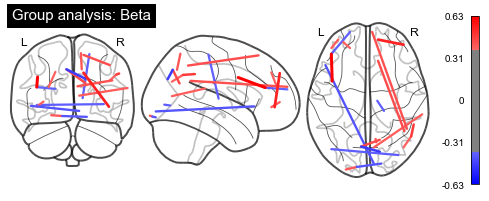

In [213]:
# plot connectome with 80% edge strength in the connectivity
fig1 = plotting.plot_connectome(adj_beta, power_coords,
                         edge_threshold='99.95%',
                         node_color='black',
                         colorbar=True,
                         node_size=0, # size 264
                         alpha=.2,
                         title='Group analysis: Beta')

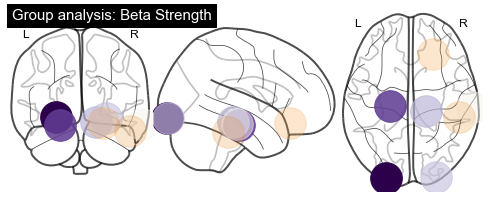

In [239]:
plotting.plot_connectome_strength(adj_beta.iloc[:10, :10], power_coords[:10],
                         cmap = 'PuOr',
                         title='Group analysis: Beta Strength')

plotting.show()

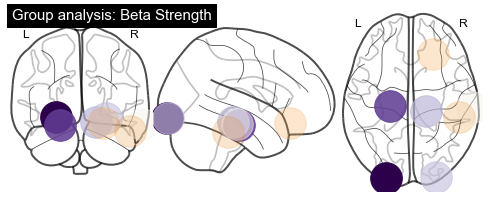

In [240]:
plotting.plot_connectome_strength(adj_beta.iloc[:10, :10], power_coords[:10],
                         cmap = 'PuOr',
                         title='Group analysis: Beta Strength')

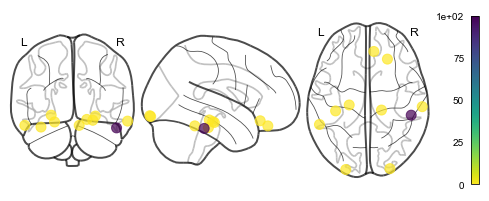

In [241]:
plotting.plot_markers(9*[0]+[100], power_coords[:10])
plotting.show()

In [211]:
np.tril(adj_beta2)

nan

In [210]:
power2011[['ROI']].shape

(264, 1)

In [190]:
def drop_coords(adj_beta, power2011):
    adj_beta = adj_beta.replace(0, np.nan)
    notna_index = np.argwhere(~np.isnan(np.triu(adj_beta)))
    ids = []
    for index in notna_index:
        roiL, roiR = index
        if roiL <= roiR:
            ids.append(index)
    notna_index_df = pd.DataFrame(ids, columns=['from', 'to'])
    from_df = pd.DataFrame()
    to_df = pd.DataFrame()
    from_df['roi'] = notna_index_df['from']+1
    to_df['roi'] = notna_index_df['to']+1
    non_na_roi = from_df.merge(to_df, how='inner', on='roi')['roi'].unique()
    non_na_power = power2011[power2011['ROI'].isin(na_roi)]
    return non_na_power

In [178]:
non_na_power = drop_coords(adj_beta, power_coords)
#na_roi = [x for x in power2011['ROI'].to_list() if x not in na_roi]

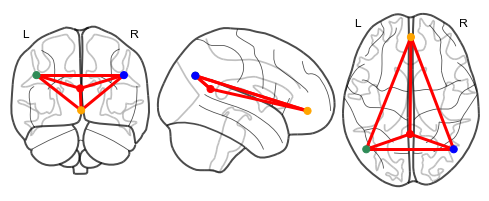

In [58]:
coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
adj_matrix = np.ones((4, 4))
plotting.plot_connectome(adj_matrix, coords, node_color=["red", "seagreen", "blue", "orange"])